In [8]:
import torch 
import torch_geometric as pyg
import pandas as pd
import numpy as np
import omnipath as op 
from matplotlib import pyplot as plt 
import torch_geometric as pyg 
import copy 
import umap
import seaborn as sbn

from gsnn.reinforce.Actor import Actor
from gsnn.reinforce.Environment import Environment
from gsnn.models.GSNN import GSNN
from gsnn.data.LincsDataset import LincsDataset
from gsnn.models import utils 
from gsnn.proc.utils import get_x_drug_conc             # required to unpickle data 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')
NS = result_dict['actor']
NS.load_state_dict(result_dict['state_dict'])
data = torch.load('../../processed_data/data.pt')

row,col = data.edge_index_dict['function','to','function']
N = len(data.node_names_dict['function'])
iD = pyg.utils.degree(row, num_nodes=N).detach().cpu().numpy()
oD = pyg.utils.degree(col, num_nodes=N).detach().cpu().numpy()
D = iD + oD

uni2sym = pd.read_csv('../../extdata/omnipath_uniprot2genesymb.tsv', sep='\t')

res = pd.DataFrame({'node_name':data.node_names_dict['function'], 'prob':result_dict['node_prob'].ravel(), 'degree':D, 'in_degree':iD, 'out_degree':oD})
res = res.assign(From=lambda x: [xx.split('__')[1] for xx in x.node_name])
res = res.merge(uni2sym, on='From', how='left')

#_ = [print(x) for x in res.sort_values('prob', ascending=False).dropna().head(50).To.tolist()]

res.sort_values('prob', ascending=False).head(10)

,node_name,prob,degree,in_degree,out_degree,From,To
6304,RNA__P04637,0.994513,90.0,1.0,89.0,P04637,TP53
3546,PROTEIN__Q5T5U3,0.992599,3.0,1.0,2.0,Q5T5U3,ARHGAP21
7853,RNA__Q14469,0.991031,16.0,1.0,15.0,Q14469,HES1
6264,RNA__P02766,0.990935,3.0,1.0,2.0,P02766,TTR
5542,RNA__MIMAT0003273,0.990629,4.0,3.0,1.0,MIMAT0003273,NaN
6285,RNA__P04090,0.990341,3.0,1.0,2.0,P04090,RLN2
667,PROTEIN__O75319,0.990103,2.0,1.0,1.0,O75319,DUSP11
305,PROTEIN__O00425,0.989865,2.0,1.0,1.0,O00425,IGF2BP3
6890,RNA__P27169,0.989621,2.0,1.0,1.0,P27169,PON1
3,PROTEIN__A1L390,0.988953,2.0,1.0,1.0,A1L390,PLEKHG3


In [10]:
res.sort_values('prob', ascending=False).tail(10)

,node_name,prob,degree,in_degree,out_degree,From,To
8868,RNA__Q9UNE7,0.012034,2.0,1.0,1.0,Q9UNE7,STUB1
7152,RNA__P45973,0.011885,4.0,1.0,3.0,P45973,CBX5
814,PROTEIN__O95433,0.011849,3.0,2.0,1.0,O95433,AHSA1
396,PROTEIN__O14896,0.011843,18.0,15.0,3.0,O14896,IRF6
5248,PROTEIN__Q9Y6D9,0.011311,19.0,3.0,16.0,Q9Y6D9,MAD1L1
7710,RNA__Q13133,0.011179,6.0,1.0,5.0,Q13133,NR1H3
6797,RNA__P22301,0.010710,19.0,1.0,18.0,P22301,IL10
5931,RNA__O15516,0.010156,6.0,1.0,5.0,O15516,CLOCK
5250,PROTEIN__Q9Y6F6,0.009756,4.0,2.0,2.0,Q9Y6F6,IRAG1
1996,PROTEIN__P33681,0.009479,51.0,30.0,21.0,P33681,CD80


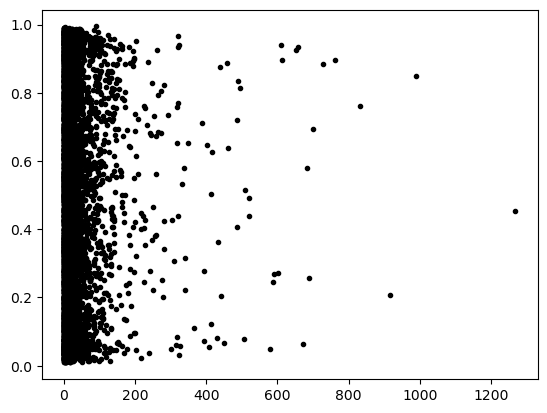

In [11]:
plt.figure()
plt.plot(res.degree, res.prob, 'k.')
plt.show()

In [12]:
row,col = data.edge_index_dict['input', 'to', 'function']
dti_idxs = col[row == 0] # 'DRUG__BRD-K60230970'
targs = np.array(data.node_names_dict['function'])[dti_idxs]
res[lambda x: x.node_name.isin(targs)].sort_values('prob', ascending=False)

,node_name,prob,degree,in_degree,out_degree,From,To
2116,PROTEIN__P40306,0.943286,32.0,27.0,5.0,P40306,PSMB10
3918,PROTEIN__Q8TAA3,0.915984,33.0,26.0,7.0,Q8TAA3,PSMA8
1849,PROTEIN__P28070,0.845323,31.0,27.0,4.0,P28070,PSMB4
1850,PROTEIN__P28072,0.835372,34.0,31.0,3.0,P28072,PSMB6
1149,PROTEIN__P07858,0.752952,18.0,12.0,6.0,P07858,CTSB
1787,PROTEIN__P25786,0.740617,29.0,26.0,3.0,P25786,PSMA1
2307,PROTEIN__P49721,0.680707,28.0,26.0,2.0,P49721,PSMB2
1851,PROTEIN__P28074,0.585442,29.0,26.0,3.0,P28074,PSMB5
2192,PROTEIN__P43235,0.556090,11.0,6.0,5.0,P43235,CTSK
1789,PROTEIN__P25788,0.545814,32.0,26.0,6.0,P25788,PSMA3


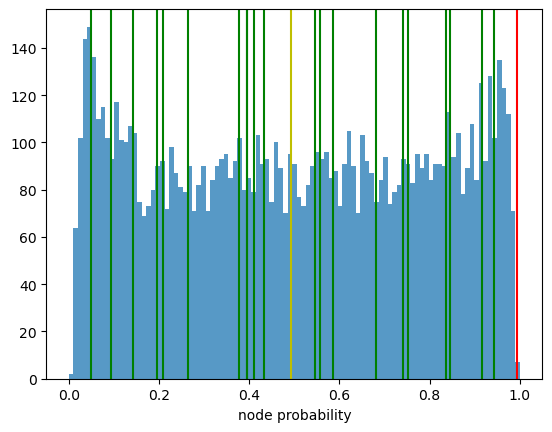

In [13]:
plt.figure()
plt.hist(res.prob, bins=np.linspace(0,1,100), alpha=0.75)
for targ in targs: 
    plt.axvline(res[lambda x: x.node_name == targ].prob.item(), c='g')

plt.axvline(res[lambda x: x.node_name.isin(targs)].prob.mean().item(), c='y')
plt.axvline(res[lambda x: x.node_name == 'RNA__P04637'].prob.item(), c='r')
plt.xlabel('node probability')
plt.show()

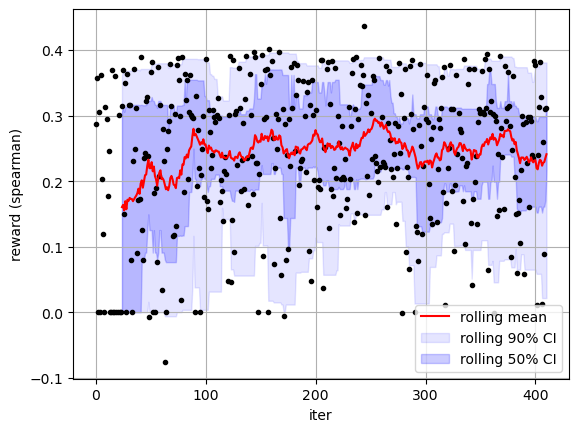

In [14]:
window=25
tmp = pd.DataFrame({'reward':result_dict['reward_scaler'].rewards})
tmp = tmp.assign(rm = tmp.rolling(window=window).mean(), 
                 rs = tmp.rolling(window=window).std(),
                 q05 = tmp.rolling(window=window).quantile(q=0.05),
                 q25 = tmp.rolling(window=window).quantile(q=0.25), 
                 q75 = tmp.rolling(window=window).quantile(q=0.75), 
                 q95 = tmp.rolling(window=window).quantile(q=0.95), 
                 )

plt.figure()
plt.plot(result_dict['reward_scaler'].rewards, 'k.')
plt.plot(tmp.rm, 'r-', label='rolling mean')
plt.fill_between(range(len(tmp.rm)), tmp.q95, tmp.q05, color='b', alpha=0.1, label='rolling 90% CI')
plt.fill_between(range(len(tmp.rm)), tmp.q75, tmp.q25, color='b', alpha=0.2, label='rolling 50% CI')
plt.legend()
plt.grid()
plt.xlabel('iter')
plt.ylabel('reward (spearman)')
plt.show()

In [93]:
z = result_dict['x'].detach().cpu().numpy() 
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
u = reducer.fit_transform(z)

zres = pd.DataFrame(u, columns=['u0', 'u1']).assign(prob=result_dict['node_prob'])

KeyboardInterrupt: 

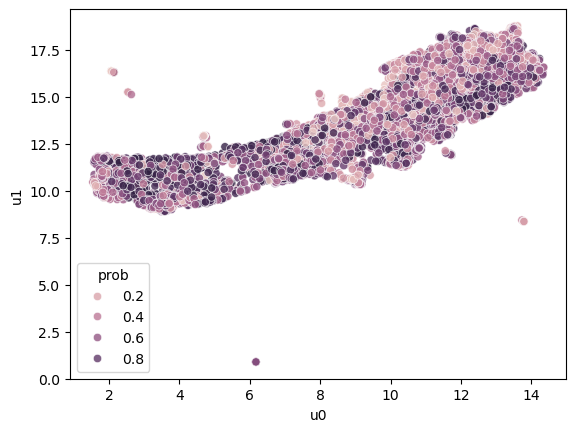

In [286]:
plt.figure()
sbn.scatterplot(x='u0', y='u1', hue='prob', data=zres, alpha=0.8)
plt.show()

In [15]:
result_dict = torch.load('../../processed_data/rl_results_dict.pt')

p = np.array(result_dict['node_prob'])
env = result_dict['env']

result_dict.keys()

dict_keys(['state_dict', 'node_prob', 'reward_scaler', 'args', 'x', 'actor', 'data', 'model_kwargs', 'training_kwargs', 'env'])

In [16]:

env.model_kwargs['checkpoint'] = False
env.train_dataset.root = '../../processed_data/'
env.val_dataset.root = '../../processed_data/'

n = 5

policy_perf = []
for i in range(n): 
        action = torch.tensor(np.random.binomial(n=1, p=p), dtype=torch.float32)
        policy_perf.append( env.run(action) )

baseline_perf = []
for i in range(n):      
        action = torch.ones((len(p), ), dtype=torch.float32)
        baseline_perf.append( env.run(action) )

rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


In [225]:
rand_perf = []
for i in range(n): 
    p_ = np.mean(p)*np.ones((len(p),))
    action = torch.tensor(np.random.binomial(n=1, p=p_), dtype=torch.float32)
    rand_perf.append( env.run(action) )

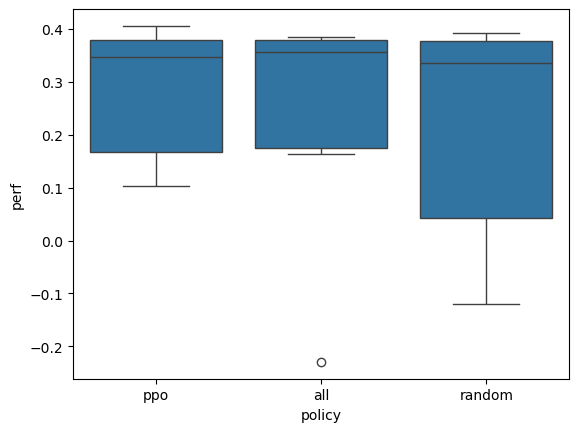

In [228]:
res = pd.DataFrame({'policy':['ppo']*n + ['all']*n + ['random']*n, 'perf':policy_perf + baseline_perf + rand_perf})

plt.figure()
sbn.boxplot(x='policy', y='perf', data=res)
plt.show()


progress: 1/10


progress: 2/10: 6/25 | train loss: 8.8 || val perf: 0.30651
progress: 3/10: 9/25 | train loss: 4.3 || val perf: 0.088973
progress: 4/10: 16/25 | train loss: 6.6 || val perf: -0.033
progress: 5/10: 9/25 | train loss: 12.3 || val perf: 0.373
progress: 6/10: 8/25 | train loss: 5.8 || val perf: 0.354956
progress: 7/10: 12/25 | train loss: 8.4 || val perf: 0.3436
progress: 8/10: 12/25 | train loss: 10.7 || val perf: 0.318
progress: 9/10: 14/25 | train loss: 13.4 || val perf: 0.3228
progress: 10/10 8/25 | train loss: 818.5 || val perf: 0.1075166


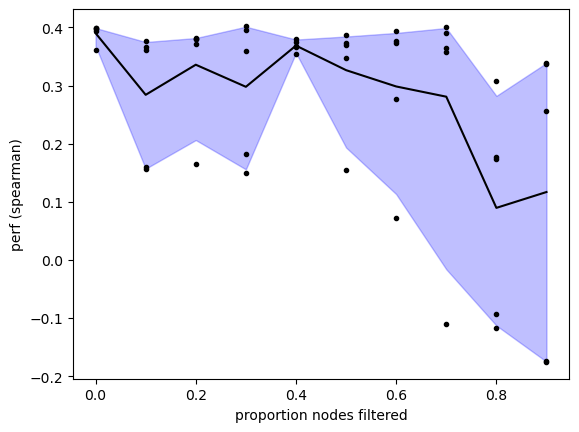

In [223]:
# this should really be done with a test dataset ... 

env.train_dataset.root = '../../processed_data/'
env.val_dataset.root = '../../processed_data/'

qs=np.linspace(0., 0.9, 10)
perfs = []

for i,q in enumerate(qs): 
    print(f'progress: {i+1}/{len(qs)}')
    repls = []
    for j in range(5): 
        t = np.quantile(p, q=[q])[0]
        action = torch.tensor((1.*(p>t)), dtype=torch.float32)
        repls.append( env.run(action) )
    perfs.append(repls)

p_mean = [np.mean(p) for p in perfs]
p_q05 = [np.quantile(p, q=[0.05])[0] for p in perfs]
p_q95 = [np.quantile(p, q=[0.95])[0] for p in perfs]

plt.figure()
plt.plot(qs, p_mean, 'k-')
plt.fill_between(qs, p_q05, p_q95, color='b', alpha=0.25)

for i in range(5): 
    plt.plot(qs, [p[i] for p in perfs], 'k.')

plt.ylabel('perf (spearman)')
plt.xlabel('proportion nodes filtered')
plt.show()